In [12]:
# imports
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

from numpy import argmax
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

import numpy as np
import cv2
import math
from scipy import ndimage
import base64

Train: (Number of examples, width, height)=(60000, 28, 28)
Test: (Number of examples, width, height)=(10000, 28, 28)


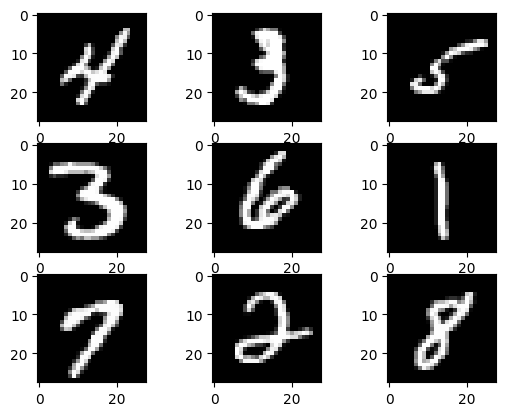

In [4]:
# visual of some testing / training data
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print(f"Train: (Number of examples, width, height)={trainX.shape}")
print(f"Test: (Number of examples, width, height)={testX.shape}")
# plot images 9-18
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i+9], cmap=plt.get_cmap('gray'))

In [5]:
# load train and test dataset
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single color channel (images only contain hand-drawn digit same size and grayscale)
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values (10 classes)
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [6]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm /= 255.0
    test_norm /= 255.0
    # return normalized images
    return train_norm, test_norm

In [7]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, accuracy = model.evaluate(testX, testY, verbose=0)        
        
        return accuracy, history, model

In [9]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

In [10]:
# plot model accuracy and loss
def summarize_model_stats(history, accuracy):
    
    print('Model accuracy = %.3f' % (accuracy * 100.0))

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    plt.title('Training and Validation Loss')
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Extract the training and validation accuracy from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot the training and validation accuracy
    plt.title('Training and Validation Accuracy')
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Model accuracy = 98.650


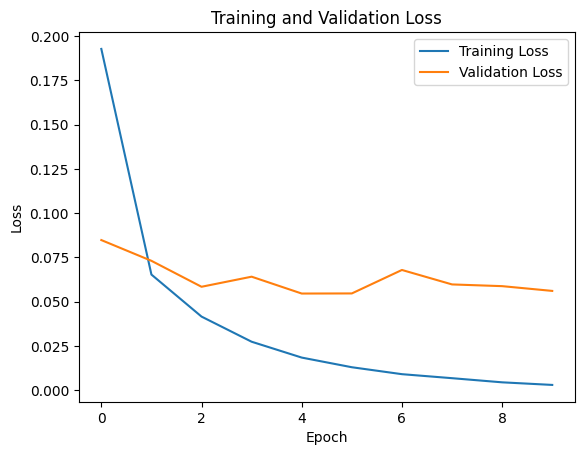

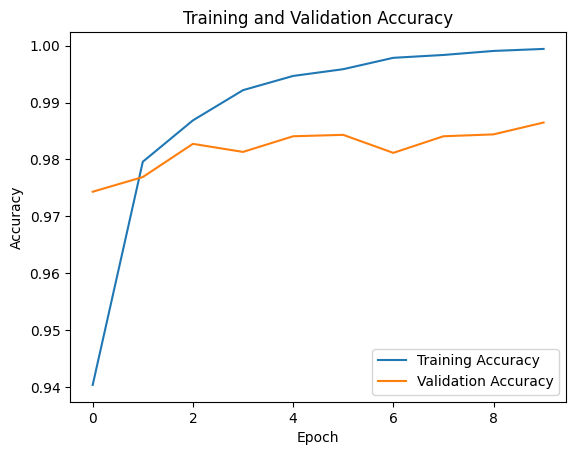

In [11]:
# evaluate model
accuracy, history, model = evaluate_model(trainX, trainY)
# summarize model stats
summarize_model_stats(history, accuracy)

In [12]:
# save model to cwd
model.save('final_model.h5')
print("Saved model to cwd under name 'final_model.h5'")

Saved model to cwd under name 'final_model.h5'


In [28]:
# predict new images
def load_image(filename):
    # load the image
    img = load_img(filename, color_mode="grayscale", target_size=(28, 28))
    plt.imshow(img)
    plt.show()
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img /= 255.0
        
    return img

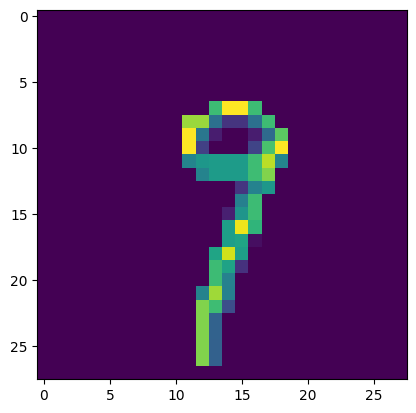

1/1 [==============================] - 0s 41ms/step
9


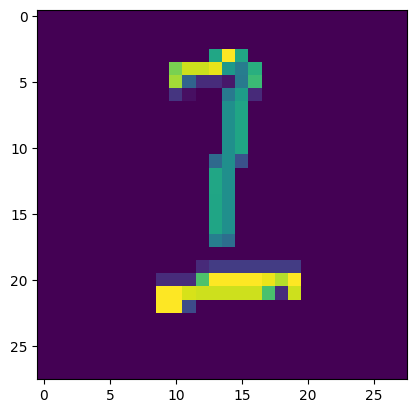

1/1 [==============================] - 0s 38ms/step
1


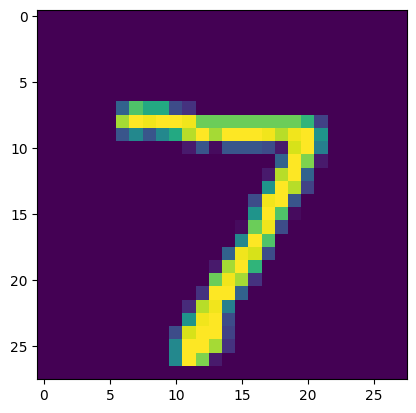

1/1 [==============================] - 0s 40ms/step
7


In [32]:
# load an image and predict the class
def predict_img(filepath):
    # load the image
    img = load_image(filepath)
    # load model
    model = load_model('final_model.h5')
    # predict the class
    predict_value = model.predict(img)
    digit = argmax(predict_value)
    print(digit)

#testing with some images
predict_img('fixed_9.png')
predict_img('fixed_1.png')
predict_img('from_dataset.png')

In [1]:
def getBestShift(img):
    cy,cx = ndimage.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

In [2]:
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [23]:
# next step would be to create dataset of actual handwritten data so you would not have to
# pre-process every image to look similar to MNIST dataset

def guess_number(is_file, file_info):
    
    # if it's a file read it otherwise uri so split it
    if is_file:
        # show original image
        plt.title('Original Image')
        plt.imshow(cv2.imread(file_info, cv2.IMREAD_COLOR))
        plt.show()
        gray = cv2.imread(file_info, cv2.IMREAD_GRAYSCALE)
    else:
        uri = file_info

        encoded_data = uri.split(',')[1]
        nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
        # show original image
        plt.title('Original Image')
        plt.imshow(cv2.imdecode(nparr, cv2.IMREAD_COLOR))
        plt.show()
        gray = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

    # resize the images and invert it (black background)
    gray = cv2.resize(255-gray, (28, 28))

    # show inverted image (black background)
    plt.title('Black Background Inverted')
    plt.imshow(gray)
    plt.show()

    (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape

    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows))

    # show resized image
    plt.title('Resized Image')
    plt.imshow(gray)
    plt.show()

    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    gray = shifted

    # show shifted image
    plt.title('Shifted Image')
    plt.imshow(gray)
    plt.show()

    gray = gray.reshape(1, 28, 28, 1)
    # prepare pixel data
    gray = gray.astype('float32')
    gray /= 255.0

    model = load_model('final_model.h5')
    # predict the class
    predict_value = model.predict(gray)
    digit = argmax(predict_value)
    print("Final guess: ", digit)
    return digit

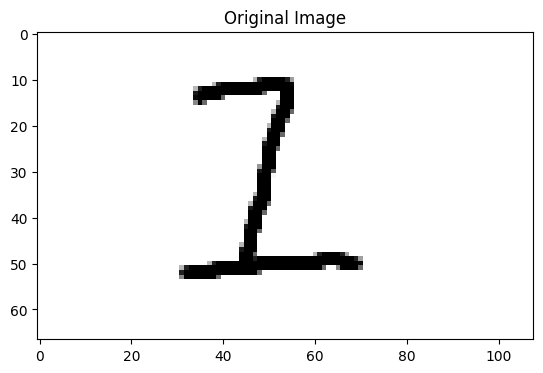

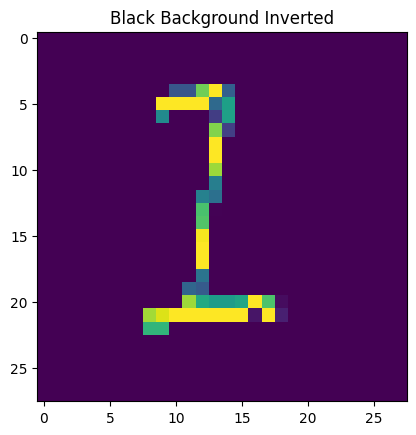

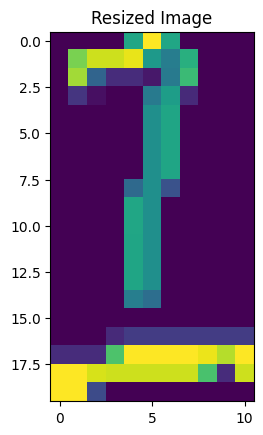

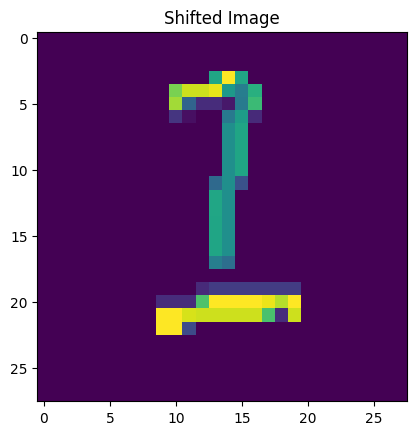

1/1 [==============================] - 0s 33ms/step
Final guess:  1


1

In [24]:
# test on pixel drawn 1 (saved as file)
guess_number(True, "1.png")

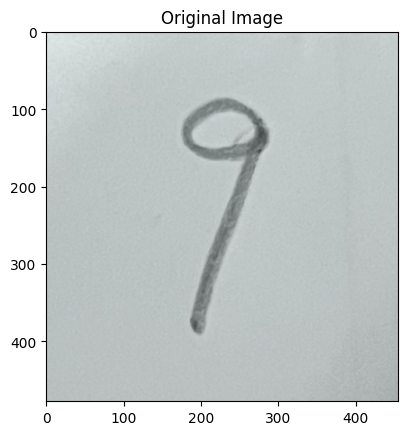

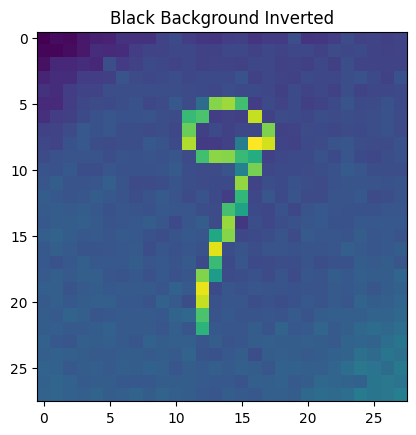

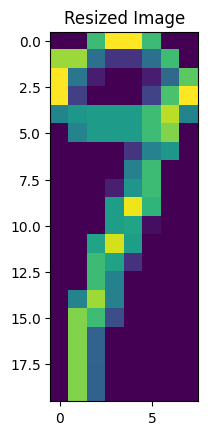

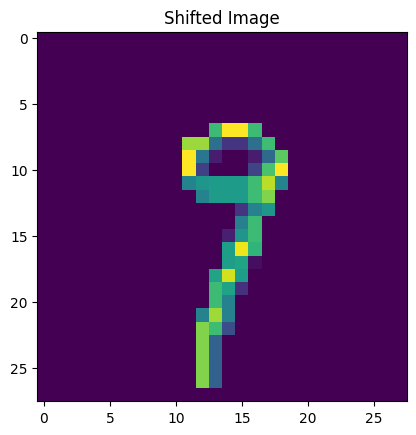

1/1 [==============================] - 0s 33ms/step
Final guess:  9


9

In [25]:
# test on handdrawn 9 
guess_number(True, "9.png")

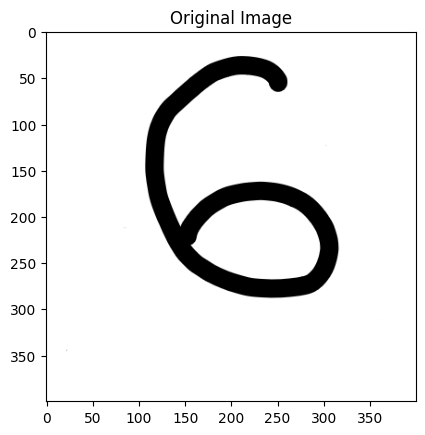

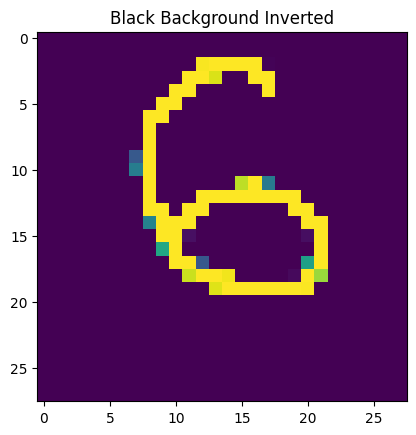

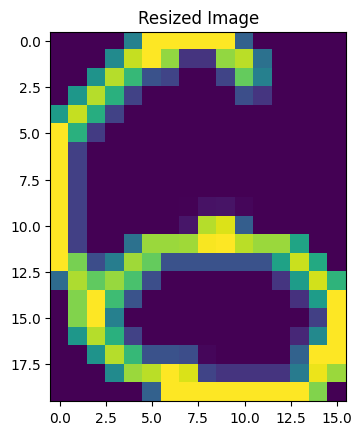

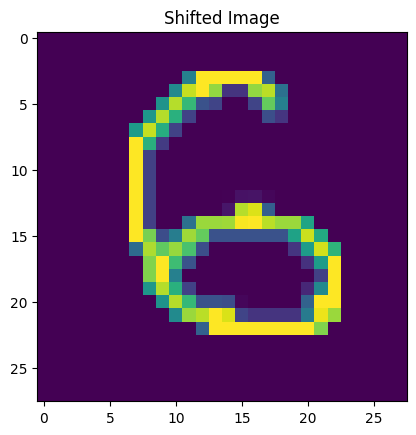

1/1 [==============================] - 0s 41ms/step
Final guess:  6


6

In [26]:
# test on canvas drawn 6 (saved as data uri)
guess_number(False, "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAYAAACAvzbMAAAgAElEQVR4Xu2dCfwW0/fHT4uyRKSFFG1IFEmL5FdCK5UkikpFqCxlq5RKikiKJHubrVULWVpsLZRoIWmxpIR2S0T1d+bvi1S+32eeOzP3zrzP6zWvJ5p77rnvMz2fZ2buvSfb7j9MMAhAAAIQgECKBLIhICkS43QIQAACEPAIICBcCBCAAAQg4IsAAuILG40gAAEIQAAB4RqAAAQgAAFfBBAQX9hoBAEIQAACCAjXAAQgAAEI+CKAgPjCRiMIQAACEEBAuAYgAAEIQMAXAQTEFzYaQQACEIAAAsI1AAEIQAACvgggIL6w0QgCEIAABBAQrgEIQAACEPBFAAHxhY1GEIAABCCAgHANQAACEICALwIIiC9sNIIABCAAAQSEawACEIAABHwRQEB8YaMRBCAAAQggIFwDEIAABCDgiwAC4gsbjSAAAQhAAAHhGoAABCAAAV8EEBBf2GgEAQhAAAIICNcABCAAAQj4IoCA+MJGIwhAAAIQQEC4BiAAAQhAwBcBBMQXNhpBAAIQgAACwjUAAQhAAAK+CCAgvrDRKEkEtm7dKkuWLJGvv/5a1qxZ89exdu1a2b59u/z888+yY8cO2b17t3fkzJlT8uTJ89dxyCGHeH/OmzevFClSZI+jWLFikjt37iThZKwxIoCAxCiZDCV9Art27ZK5c+fKggUL5IMPPvA+ly1blr7j//BQsmRJOfHEE+WEE07wPitWrCgVKlQItE+cQ8AEAQTEBEV8OE1AhWLmzJl/HXo3EbXpXYkKyRlnnCGVK1eWWrVqSb58+aIOi/4hsAcBBIQLInEEfv31V5k8ebJMmTJF3njjDVm/fr0TDM4++2xPSPSoVKmSEzETZLwJICDxzi+j+5PAli1bZNKkSZ5oqHj89ttvTrMpXry4tGzZ0jtKlCjh9FgI3l0CCIi7uSPyTAjs3LlTXnjhBRk/frxMnDgxtrwaNmworVu3Fv3EIBAmAQQkTNr0FQqB2bNny+jRo+W5556Tbdu2hdKnDZ3Url1bunTpIjVq1LAhHGJIAAEEJAFJTsIQN2/eLMOHD5eRI0fKRx99lIQh73eMzZo1k3vuuUeOO+64RHNg8METQECCZ0wPARL4+OOP5YEHHpARI0aITsHF/p+AzuLq16+fdO7cGSQQCIwAAhIYWhwHSeDLL7+Ue++9V4YNGxZkN877btKkiTz66KOSP39+58fCAOwjgIDYlxMiyoSA3nHccccdotNxscwJFC1a1BOR+vXrZ34yZ0AgBQIISAqwODVaArNmzZJu3brJvHnzog3E0d71bu2aa65xNHrCtpEAAmJjVohpLwK33nqrDBgwADJpEtDHfrfffnuaXmgOgf8ngIBwJVhNYMaMGd6L4MWLF1sdp0vBde3a1XvBjkEgXQIISLoEaR8YAf2lfN999wXmP8mOH374YenYsWOSETB2AwQQEAMQcWGWwIcffuh9uc2ZM8esY7ztQUBX6Ddu3BgqEPBNAAHxjY6GQRAYOnSodOjQIQjX+PwXgVy5cslbb70lVapUgQ0EfBFAQHxho1EQBHSG0OOPPx6Ea3zuh0D58uVl4cKF8IGALwIIiC9sNDJJQFeTt23bVt577z2TbvGVRQK33Xab9O/fP4tncxoE/iaAgHA1REpAn8PrTrI//PBDpHEkvXOti3LeeeclHQPjT5EAApIiME43R6Bv377SvXt3cw4D9nT44Yd7pWa1SuCxxx4rusJbD615ftBBB0m2bNkke/bsXn30H3/80Tt++uknr9Jh4cKFvZrqGcdnn30mWlPdFitbtixTpW1JhkNxICAOJSsuof7+++/eXYduuW6zqTjUrFnTO1Q0ypQpYzTcrVu3yvLly2XRokVe7fX58+eLzkCLynTKtC7YxCCQVQIISFZJcZ4RAkuWLPHEQ+uQ22gqFnnz5pVevXpJuXLlQg9x+/btMn36dHn99de9z08//TS0GAoUKCDffvutdyeFQSArBBCQrFDiHCMEtCpgixYtvMc6NtkFF1wgDRo0kAsvvFCOOuoom0Lz1sKMGjUqtF2Hx4wZI5dccolVDAjGXgIIiL25iVVkgwYNkk6dOlkzJr3TuPTSS0W3O8+XL581ce0vkNWrV0vv3r29gllBmhaj0kqOGASyQgAByQolzkmLwE033SSDBw9Oy4eJxiVKlJDmzZt7x0knnWTCZeg+Jk+eLDfccINoPZQg7OSTT5alS5cG4RqfMSSAgMQwqbYMSWchXXHFFTJp0qRIQ9LHU7pIsV69epHGYarzjRs3ymWXXea9IzFtOqNM84ZBICsEEJCsUOKclAno4kAVjyjrk5966qnerrNxEY5/J0H3sdL3SqZt586d3nRkDAKZEUBAMiPE36dMQGcQ6fuFLVu2pNzWVIO77rpLevToYcqdlX50xtb//vc/bwqwSdNp1jly5DDpEl8xJYCAxDSxUQ1LX8BefvnlUXUv1apVk4EDB0rFihUjiyHMjvVO75RTTjHWJY+wjKFMhCMEJBFpDmeQDz30kNx4443hdLaPXpJw17EvuEcccYSxu73KlStTMjiyK9i9jhEQ93JmZcQ9e/YU/QKPwnRH2SFDhkjVqlWj6D7yPtu0aSPPPPOMkTiuuuoqeeKJJ4z4wkn8CSAg8c9x4CPU+h1axyMKa9++vTzyyCNRdG1Nn1r219RGiLNmzZIaNWpYMzYCsZsAAmJ3fqyPTl+W6+rlKOyxxx6Tdu3aRdG1dX3qjLdnn302rbiqV68ub775Zlo+aJwsAghIsvJtbLSbNm2Spk2biv76DdtKly7tPbKhkt7f5HVTRuXi1woVKuS9+yhWrJhfF7RLIAEEJIFJT3fIK1as8PZL0l1kw7ZGjRp54qFbq2N7EtDZZzfffLMvLK+88orUrVvXV1saJZcAApLc3Psauf5KVfHQuhZhW9euXb2Fgdj+CUybNs3b7Vh31c2K6QyuO++8U3S7GQwCqRJAQFIlluDzp06d6j220gVsYZquita7jpYtW4bZrbN9ff7556KzqbSQ1X9Z586dPfHQ7esxCPghgID4oZbANsOHD/d+2YZtWsRJxaNSpUphd+18f/qIUfchW7x4sXz11VdywAEHSMGCBb13R/Xr1ze6ANF5WAzAFwEExBe2ZDUaMGBAJJXqdA8rrVqoj1kwCEDAPgIIiH05sSqiLl26SP/+/UOPifUdoSOnQwikTAABSRlZchroc/Snnnoq9AFTmzt05HQIAV8EEBBf2OLfSGdajRs3LtSB5sqVy3tkRUnVULHTGQR8E0BAfKOLZ0MtJnTxxReLbskepukCthdffJGX5WFCpy8IpEkAAUkTYCrNd+/e7Z2eLVu2VJqFdu66des88dC1HmFahQoVZOzYsVK8ePEwu6UvCEAgTQIISJoA/6v5rl27nKns9tlnn8lFF10kn3zySYBE9nZdu3Ztby+tww47LNR+6QwCEEifAAKSPkPnPeg6Ad0iRBeghWlaeErfeWAQgICbBBAQN/NmLOoPPvhALrzwQvnmm2+M+cyKIy08NWjQoKycyjkQgIClBBAQSxMTRlgLFy70ViSvX78+jO7+6iOplQNDhUxnEAiBAAISAmQbu1i2bJmcf/75snbt2lDD08JT1113Xah90hkEIBAMAQQkGK5We9XZVlrBTkUkTNNpuroZIwYBCMSDAAISjzxmeRQ7duwQrTwX5lTdfPnyeTOtzj333CzHyYkQgID9BBAQ+3NkNEITpU9TCej444/3xOO0005LpRnnQgACDhBAQBxIkqkQ+/btK927dzflLlM/VatW9cTjmGOOyfRcToAABNwjgIC4lzNfEb/22mtSp04dX239NGrQoIEnHrlz5/bTnDYQgIADBBAQB5JkIsSyZcvK0qVLTbjK1EebNm0i2cU308A4AQIQMEoAATGK005nt912m9x///2hBHfrrbeKbseOQQAC8SeAgMQ8x7NmzZKaNWuGMso+ffqE+o4llEHRCQQgsF8CCEjML46zzjpL5syZE/godVsS3Z4EgwAEkkMAAYlxrocNGxbKqu+nn35aWrduHWOSDA0CENgXAQQkpteFFoYqVaqUfPvtt4GOUGdaUUEwUMQ4h4C1BBAQa1OTXmC33HKLPPDAA+k5+Y/WWhRr0qRJ3k6+GAQgkEwCCEgM8758+XIpXbp0oCObOnWqt5MvBgEIJJcAAhLD3F955ZUyYsSIwEY2YcIEr3ohBgEIJJsAAhKz/M+fP18qVaoU2KiGDx8urVq1Csw/jiEAAXcIICDu5CpLkTZr1kxeeOGFLJ2b6kl33nmn9O7dO9VmnA8BCMSUAAISo8QuWLBAKlasGMiIdCv26dOnB+IbpxCAgJsEEBA387bPqHUPqmeeeSaQEWn52/LlywfiG6cQgICbBBAQN/O2V9QbNmyQAgUKBDKanj17Sq9evQLxjVMIQMBdAgiIu7nbI3LdLFE3TTRtJUqUkFWrVpl2iz8IQCAGBBCQGCRRh1CmTJlAapyPHDlSWrRoERNKDAMCEDBJAAExSTMiX7qoL4gV4eeff768/vrrEY2KbiEAAdsJICC2ZygL8TVu3FgmTpyYhTNTO2XmzJlyzjnnpNaIsyEAgcQQQEAcT/XatWulSJEixkehGyTqRokYBCAAgf0RQEAcvzYeffRRad++vfFRzJ07V6pUqWLcLw4hAIH4EEBAHM9lvXr1ZNq0aUZH0aRJExk7dqxRnziDAATiRwABcTinmzdvlnz58hkfwWuvvSa1atUy7heHEIBAvAggIA7nU3fc1Z13TZquNtdV5xgEIACBzAggIJkRsvjvW7ZsKaNGjTIa4cMPPywdO3Y06hNnEIBAPAkgIA7n9ZhjjpF169YZG8GBBx4omzZtkoMOOsiYTxxBAALxJYCAOJrbDz/8UE4//XSj0Tdt2lRefPFFoz5xBgEIxJcAAuJobrXeudY9N2n6OOyKK64w6RJfEIBAjAkgII4mt1GjRjJp0iSj0W/dulUOO+wwoz5xBgEIxJcAAuJobosVKyZffvmlsegvuOACmTJlijF/OIIABOJPAAFxMMfff/+9FCxY0GjkAwcOlE6dOhn1iTMIQCDeBBAQB/P7xhtvGF/ot2jRIilXrpyDNAgZAhCIigACEhX5NPo1XTyqaNGi8tVXX6UREU0hAIEkEkBAHMx6q1atRAs9mbIGDRoYfyFvKjb8QAAC9hJAQOzNzX4jO+uss2TOnDnGIu/Ro4fcddddxvzhCAIQSAYBBMTBPBcqVEi+++47Y5GPHz9etCgVBgEIQCAVAghIKrQsODeIHXhXrFghpUqVsmB0hAABCLhEAAFxKVt/xLpgwQKpWLGisaizZ88uO3fuNOYPRxCAQHIIICCO5XrChAly8cUXG4v6hBNOkOXLlxvzhyMIQCA5BBAQx3L9yCOPGN1uvX79+jJ16lTHKBAuBCBgAwEExIYspBDDHXfcIf369UuhxX+fqrU/tAYIBgEIQCBVAghIqsQiPr9NmzbyzDPPGItCxahr167G/OEIAhBIDgEExLFc16lTR7RmuSlTMTJdFtdUbPiBwP4IfPrpp1K6dGkARUwAAYk4Aal2rzOwdCaWKVMxqlWrlil3+IFAaAR++eUX0SqaWHQEEJDo2PvquWTJkrJ69WpfbffViE0UjaHEEQQSRwABcSzl+fLlE11MaMrWrFkjRYoUMeUOPxCAQIIIICAOJXvXrl2SI0cOoxH/9NNPcvDBBxv1iTMIQCAZBBAQh/K8ceNGyZ8/v7GIc+fOLfocGYMABCDghwAC4odaRG1Wrlwpxx9/vLHejz76aFm3bp0xfziCAASSRQABcSjfH330kZQvX95YxCeffLIsXbrUmD8cQQACySKAgDiU73fffVfOPvtsYxFXrlxZ5s2bZ8wfjiAAgWQRQEAcyverr74qdevWNRbxueeeK9OnTzfmD0cQgECyCCAgDuV73LhxcskllxiLuGHDhvLSSy8Z84cjCEAgWQQQEIfyPXz4cGndurWxiC+//HIZPXq0MX84ggAEkkUAAXEo30OGDJHrr7/eWMTXXHONDBs2zJg/HEEAAskigIA4lO/77rtPbr/9dmMR33zzzTJgwABj/nAEAQgkiwAC4lC+e/fuLb169TIWcffu3aVPnz7G/OEIAhBIFgEExKF8d+nSRfr3728s4r59+0q3bt2M+cMRBCCQLAIIiEP5vummm2Tw4MHGIh44cKB06tTJmD8cQQACySKAgDiU72uvvVYee+wxYxFrffX27dsb84cjCEAgWQQQEIfybbqc7VNPPSXqE4MABCDghwAC4odaRG2uuOIKefbZZ431PmrUKFGfGAQgAAE/BBAQP9QiatO0aVMZO3assd5ffPFFUZ8YBCAAAT8EEBA/1CJq06hRI5k0aZKx3idOnCjqE4MABCDghwAC4odaRG3q168vr7zyirHeX375ZalXr54xfziCAASSRQABcSjfDRo0kClTphiLeOrUqaKihEEAAhDwQwAB8UMtojYXXXSR0d1zJ0+eLBdeeGFEo6FbCEDAdQIIiEMZvPjii2XChAnGIuYdiDGUOIJAIgkgIA6l3fQsrPHjx0vjxo0dIkCoEICATQQQEJuykUkszZo1kxdeeMFYxE8//bTR+iLGAsMRBCDgBAEExIk0/X+Q1113ndH6HeyF5VDyCRUCFhJAQCxMyv5CMr0br+7EqzvyYhCAAAT8EEBA/FCLqI3pglLt2rUzujljRFjoFgIQiIgAAhIReD/dPvPMM0Y3P9QpvDqVF4MABCDghwAC4odaRG10EaEuJjRlZcuWlcWLF5tyhx8IQCBhBBAQhxK+cOFCqVChgrGIDz30UNm2bZsxfziCAASSRQABcSjfmzdvlnz58hmN+LvvvpMCBQoY9YkzCEAgGQQQEMfyrAKiQmLK3nvvPalUqZIpd/iBAAQSRAABcSzZp59+unz44YfGoqYmiDGUOIJA4gggII6lXLce0T2sTJmuA9H1IBgEIACBVAkgIKkSi/j8zp07y4MPPmgsCi1pq6VtMQhAAAKpEkBAUiUW8fkPPfSQ3HjjjcaiOOOMM2T+/PnG/OEoPQI///yz/PTTT6KfehxwwAHekTNnTjnkkEPk8MMPT68DWkPAIAEExCDMMFxpESiTNTz0S+nHH38MI/RE9vHNN9/IunXrZO3atbJ+/XrZuHHjHseGDRv++u9NmzbJ7t27/5OTColOpDjyyCO9Q2fQHXPMMVKkSBHvU4/ChQvLscceKwcddFAimTPo8AggIOGxNtLTqlWrpFSpUkZ8ZThZvXq1FC9e3KjPJDnbunWr6BqdJUuWyIoVK2TlypXe5xdffCE7d+6MDIWKSokSJeSEE06QMmXKyEknneTNuDM9FTyyAdJx5AQQkMhTkHoABx98sGzfvj31hvtpQW30rKPUuwQVC50Jl/G5fPnyrDuw4MxTTjlFKleu7B1VqlQR3ZEAg4AfAgiIH2oRtzE9lfeBBx4QfTmP7U1g2bJlMnfuXO+YN2+eLF26NHaY9JFXjRo15JxzzvE+Td/hxg4YA/qLAALi4MVw+eWXy3PPPWcs8rZt28qTTz5pzJ/LjvSx04wZM/46dKV+0kzvSHTPNT1YZJq07Kc2XgQkNV5WnH333XdLjx49jMWijzH0F3ZS7YMPPpBx48aJTlCI4x1GOnnVuxEVEv3Rone+GAT+SQABcfB60C+7Sy65xFjkhx12mOiL4CSZvujWuzitC8+OxFnLfLVq1UTXDemhs/cwCCAgDl4Dn3zyiZx88slGI9fZXTpjJ+42a9Ysr4iWbuGC+SOg04Ovuuoq0Uefp556qj8ntIoFAQTE0TTqegCTU0RfeukladiwoaM0Mg975MiR8vjjj8vs2bMzP5kzskygXr16cs011xitU5PlzjkxcgIISOQp8BdAuXLlvHUHpqxXr17Ss2dPU+6s8TNhwgTp16+f6HsOLDgC5cuXl/bt23t3JlhyCCAgjuba9EwsfVE6adIkR2nsHfacOXNEJxtMmzYtNmNyYSD6GPS2227z7kqw+BNAQBzN8T333GN0F92CBQvKt99+6yiNv8PWrUP0bkofV2HREdB3dLfeequ0atUquiDoOXACCEjgiIPpQFePX3DBBUadL1q0SPTRmKt2//33e+KhmxBidhDQEsyaE9PXqh2jIwoExNFrQDfn072OTNqQIUOkQ4cOJl2G4kvro+iXFNNxQ8HtqxO9rgYMGCAHHnigr/Y0spMAAmJnXrIUle64umbNmiydm5WTdJffyZMnZ+VUK87RR276mIR6JlakI9Mg9P2IbpvTqFGjTM/lBDcIICBu5GmfUV588cWis4xMWa5cubxaFDpF2HZ7+umnPfHQzQ0xtwjo3Yje7WLuE0BAHM7hoEGDpFOnTkZHMGXKFKufV+teVTfffLNR4TQKEGdZIlC9enVv/zU2bswSLmtPQkCsTU3mgS1YsEAqVqyY+YkpnNG6dWvRX/c2mq4ev+6662Tz5s02hkdMKRLQuiRPPfUUj7RS5GbT6QiITdnwEUv+/Pm9inamLG/evLJlyxZT7oz5MV0L3lhgOEqbgE5J79KlS9p+cBA+AQQkfOZGe2zevLk8//zzRn3qrCZbXnRqPY6rr746MVuQ6HuoPHnyeJsVauEwtd9++01++OEH74fCrl27jObaFmf6A0FfsGNuEUBA3MrXXtGOGDFCrrzySqOj0FXuo0ePNurTjzPddbhNmzbel6fLdvTRR3t1yjPqleuizYya5vqpd5EZ/607I/+X6eO7jLrqOpVbj6+//tr71EPfEenhorVo0UJ0zzLMHQIIiDu52mekuvJav5xMWo4cObz3DIceeqhJtyn56t27t7e2wyVTEdA9obRuhn5qLfLjjz8+dI56x/LZZ5+J3r3pHmDvvfeeV03RZBnkoPKimzPqVHK9BjH7CSAg9uco0wirVq1qvCCUbgWij46iMH1RPmzYsCi6znKfBxxwgJx55pleTXGdyKCCUbJkySy3j+LE+fPny1tvvSVvvvmmd+iUbRutdu3anojo4zzMbgIIiN35yVJ0usJX10SYtJo1a3plXcM205tEmopf78aUyf/+97+/hCNbtmym3Efi5+233xbdEke/rD/99NNIYthfp7Vq1ZLXXnvNqpgIZm8CCEgMrorVq1cH8ut3+fLl3mOYMOzXX38VXRipX2i22HHHHSdNmjQRXaGv6xbibPqo69lnn/XefX3//fdWDLVZs2Ze1UjMXgIIiL25SSky/WX8zjvvpNQms5O7d+8uffr0yew0I39fp04da35xak0L/fLSO44k2gsvvOCtz5g+fXrkw+/YsaM8/PDDkcdBAPsmgIDE5MoIYlV6sWLF5PPPPw+ckOktWfwErGVau3XrJtdee603KwoT7wV8y5YtvZfxu3fvjgxJXIudRQbUYMcIiEGYUbrSqZxFixY1HoIWmdJiU0GZfkFFvRniDTfcIHfccYfo9FpsbwL6SOvRRx+VoUOHRlYzZvjw4dQWsfDiREAsTIrfkPRZ/dSpU/0232e7Sy65RMaMGWPUZ4YzLYGqX0xRmb7f6NGjh9M1UMJkp3chAwcOFK27EkXxMZ1Bpo9qMXsIICD25CLtSPSFo85iMm16d6OL4Eya1l+/6667TLrMsq9TTz3VW2Niy2r7LAduyYm6ziSjeJf+OSzTO+zZs2cHcqcd1hji1g8CEqOM6jYXRxxxhGzbts3oqPr27Wu0fO4jjzwi+nI0bNPtQVQ4brnllrC7jmV/K1as8HZG1h2cw7KoppeHNT7X+kFAXMtYJvFec801xuuB61RendJrwsaOHStNmzY14SolHzqrSn81m76TSimImJ4c9g8CXWiq72Ow6AkgINHnwGgEujgsiDUL+m6lfv36acWqjx/0GXaYGwLqPlQqHEE82ksLRswa6xTytm3bit6VhGG6U4H+WMKiJYCARMs/kN51W42PPvrIqG+daqubG/q1DRs2eCu4V65c6ddFyu0uvfRSuffee0WnI2PBE9D901REdDfnoE13AdBpxnqtY9ERQECiYx9YzzpTRp9Nm7Z0VqZfcMEFoa4yVwamqzWa5hlXf1qyNoxHTJUrV/Y2icSiI4CARMc+sJ6/++47KVSokHH/+oWsX8ypWpjFoE466SSvVKpuMIlFR0Bn2OlMu6BN1+/cfffdQXeD//0QQEBiemnoS2PdksKk6Wptnf+fyjbvjz32mLe6OwzTdR26BUdmNTXCiIU+RPr16+ct0AzadLv6SpUqBd0N/vdBAAGJ6WXx6quvSt26dY2P7r777svyzr/6jPqMM84wHsO+HGpJVC2NitlFoH///oGXq61Ro4bMmjXLroEnJBoEJMaJLlOmjLePkUkrUaKErFq1KksutU7GggULsnRuOifpho+68SNmJwFddxN0uVreeUWTewQkGu6h9BrUrz8tO6rlR//LwtqmBPEI5VJKu5MgHqn+Mygt8KU/lmwv6pU2SMscICCWJcRkOPq+4qijjjLp0vOlL6h1Tcf+LKzFgjy2Mp7awBzu3LlTqlWrFuisqXSnmgc2+Bg7RkBinFwdWqtWrUTvGEzb66+/Lueff/5ebn/++WfRR2dffvml6S738Hf99dfLQw89FGgfODdLQB99nnXWWYFuxKhFsZo3b242cLztlwACEvOLQ1cIB7GDaePGjWX8+PF70QtjDYCuKtfKeZh7BLRI1b5+eJgaSbly5WTRokWm3OEnEwIISAIuEd2ALohZKvoPVf/BZlhQM7/+mSL98tG7H8xdArrIUH9oBGVaIiCsqeNBjcEVvwiIK5lKI06t56Hbepi2f29qF5RQZcStYqVCmC9fPtNDwV/IBPQLXtcIBWFhVdIMInbXfCIgrmXMZ7xBTOnVUNavX++ten/ppZfkoosu8hld5s20zKw+jitdunTmJ3OGEwROP/10+fDDDwOJVReUtmnTJhDfOP2bAAKSkKtBXx3b2d8AABSWSURBVDjfeOONxkebUa866LsPE7sBGx88DtMioCvIq1SpkpaP/TVmn6xAsO7lFAEJh3PkvezYscO7U9iyZYvRWPTO4OWXXxb9BxuUsUgsKLLR+9UFoFqwLAh744035LzzzgvCNT7/JICAJOhS6Nq1q7e9uWnTqZn/tS4knf605oPWfsDiS0DfbS1ZssT4APURlj7KwoIjgIAYZrt27VrJmTOn5MmTRw488EDJkSOH4R78u9O1GUHUxsiePXsgRaIqVKgQylYo/onS0gSBadOmSb169Uy42sOHbvqpd9x6fWLBEEBAguFqrdfWrVvL8OHDrY3vn4HNnz8/tM0YnQAS4yB1Rl8Qd5q6I3UQMxBjnIqUhoaApITL/ZPff//9QN9XmCKkdbZ1Py0sGQT0zv2UU04x/o6O7U2CvX4QkGD5WuldHxfoYwNbjX/0tmYm2LiC2vxz27ZtKdWwCXaU8fKOgMQrn1kazZQpU6RBgwZZOjeKk/SFPBUFoyAffZ+FCxeWb775xmggPMYyinMPZwhIcGyt9qwvqBcuXGhdjFo74v7777cuLgIKh0Dv3r1F1xaZtJYtW8qIESNMusTXnwQQkIReCjq98aqrrrJu9DqdU5+FY8kksHr1auM1PY488kjZsGFDMoEGPGoEJGDANrs/4YQTZMWKFdaEWL16dXnzzTetiYdAoiEQxK4GM2bMEPWLmSWAgJjl6ZS3IUOGiNbVsMUefvhh6dixoy3hEEdEBHQ6r07rNWndunULbMW7yThd84WAuJYxw/EWLVpUvv76a8Ne/bn75JNP5KSTTvLXmFaxIbBx40bRLXJMmtbEeeutt0y6xNcfBBCQhF8G+sL6tttui5zC0UcfLevWrYs8DgKwg0Dt2rWN1n3R1ei//PKLaO10zBwBBMQcSyc96SaLOnVSf/VFaRSKipK+fX0PHjxYbrrpJqOBzZw5U8455xyjPpPuDAFJ+hXwx/jvvvtu6dGjR6Qk7rrrrshjiBQAne9BQCd36CQPk6a7/uq7EMwcAQTEHEtnPW3fvl2KFCkimzZtimwM+nw6iNrtkQ2IjtMmYHqX3rZt28qTTz6Zdlw4+JsAAsLV4BHo16+f3HHHHZHQ0McK+ngBg8A/CeheaFrf3JTVqFHDK4mMmSOAgJhj6bSnX3/91bsLiWLB1aRJk6zeWsXpxDoc/HPPPSeXX365sREcd9xx8sUXXxjzhyNmYXEN/IOAFpvSolNhmm4xoVtNYBD4N4HPP/9cSpQoYRSM/lDKlSuXUZ9JdsYdSJKz/6+x79q1yys4tWbNmlCoaJ12mxYyhjJoOkmJgBZk0+vSlOlWKcWLFzflLvF+EJDEXwJ7Ahg6dKh06NAhUCpaAleFg0I/gWKOhfNSpUrJqlWrjI1l0aJFoi/nMTMEEBAzHGPlxfTsl3/CqVu3rrzyyiux4sVggiNQuXJl0SJopuydd96RatWqmXKXeD8ISOIvgb0BPP/889K8efPAyDzxxBNW7gQc2IBx7JuALjCdPn267/b/bvjyyy8HUn/dWICOOUJAHEtYWOHq1Nogd8adN2+eE6V1w+JNP/smoNUpJ0yYYAwPxaWMofQcISBmecbGmy7s03nzQZlumqhz8gsVKhRUF/iNAYEWLVrI6NGjjY3k2WefDfTu2ligjjhCQBxJVBRhtmvXTvRxU1CmK89VRHSjOwwC+yKAgNh9XSAgducn0uh0UaHuR7R58+bA4tBHFOPGjQvMP47dJlC1alWZO3eusUFMnDhRGjVqZMxf0h0hIEm/AjIZ/2OPPSbXXnttoJTUv8ktKwINFuehEihQoIDR3RHefvttOfvss0MdQ5w7Q0DinF1DY7vwwgtl6tSphrzt202bNm1E67RjEMggsHbtWm97HZOmu/zq2hLMDAEExAzHWHtZtmyZlClTJvAx6r5HJl+YBh4wHQRK4NVXXxVdN2TKdFX777//bsodfv4ggIBwGWSJwMCBA+Xmm2/O0rnpnNSkSRMZO3ZsOi5oGxMCpqtl6sw/LZuMmSOAgJhjGXtPderUkddeey3wcerisTFjxsjhhx8eeF90YC+Bpk2bGv0xwYQN87lGQMwzja1HfZR1yimnGN3cbn+wypcvLy+++KIcf/zxseXJwP6bwLHHHmt0Y89evXpJz549wW6QAAJiEGYSXIUxKyuDo75AHTlyJHWsk3Bh/WuMK1euNP7jYfz48dK4ceME0gxuyAhIcGxj6/mqq64KdcbUPffcI126dIktTwa2N4HBgwfLTTfdZBTNZ599ZlyUjAbooDMExMGk2RCy6V1SMxvTueeeKwMGDJDTTjsts1P5+xgQqF27trz++uvGRqJb5qxfv96YPxz9PwEEhCvBF4GlS5eK1vXYtm2br/Z+G/Xt21e6devmtzntHCDw/fffS8GCBY1G2rBhQ3nppZeM+sQZAsI1kAYB0/P0sxqKCpdO8TzzzDOz2oTzHCKguxK0b9/eaMRarvn222836hNnCAjXQJoERo0aFVlN8+7du0ufPn3SHAHNbSOgjytnzpxpNCwtTVC9enWjPnGGgHANGCAQ1iLDfYWq033112WtWrUMjAQXURPQmuUlS5Y0Gkb+/PlFH4th5gnwDsQ800R67Nq1q/dFHpXpI4/+/ftLnjx5ogqBfg0QCOI6atmypYwYMcJAdLj4NwEEhGvCGIGwp/f+O/Cjjz5a7r77btGNGTH3COzcudN7eb5p0yajwVOF0CjOPZwhIMGxTaTnDh06yNChQyMdu26Fou9GdKox5g6B++67L5AX3TpT8NBDD3UHhEORIiAOJcuVUDt37iwPPvhg5OG2bt1aNBbdfgWzm8DGjRulePHi8sMPPxgNlM05jeLcyxkCEizfxHoP4lm2X5hXXnmlJyRly5b164J2ARPo1KmTDBo0yHgvPL4yjpRHWMEixXsGAd28rnfv3tYAQUisScUegSxcuFAqVKhgPDidULFlyxbROiBYMAS4AwmGK17/JDBkyBC5/vrrreLRqlUrufrqq72V9Fj0BILaFocql8HnFgEJnnHie9Bt2S+77DLrOGht7LZt24oKChYNAf1xoT8ygrC5c+dKlSpVgnCNzz8JICBcCqEQ0JXFWrLWxg3tdPpvu3btvKNw4cKh8KATkeHDh4tOdAjCatasKTNmzAjCNT7/QQAB4XIIjcBXX33l/eKfPn16aH2m2pF+oemhdydYcASCvit9/vnnrbzrDY5oNJ4RkGi4J7rXW2+91dua3WY7+eSTpVmzZt6XkOmtNWwedxixTZ48WXR33KCsRIkSsmrVqqDc45c7EK6BqAlobXUtGPTpp59GHUqm/es+WyomDRo0kHz58mV6Pifsn8CkSZO8qoC7du0KDNMjjzxifDffwIJ13DF3II4n0OXwf//9d7nllltEq8+5Yuecc47UrVvXO1igmFrWgqgy+O8ITj/9dPnggw9SC4yzfRNAQHyjo6EpAlp5Th9rLV682JTLUPyceOKJf4kJuwHvH/k333zjlSTW+vZBG3XPgya8p38EJFze9PYfBGxavZ5qonTRmu7BlXGUKlUqVRexOl8fUeljyrFjx8ro0aPlt99+C3x89erVk5dffjnwfujgbwIICFeDVQTeffdd725k3rx5VsWVajClS5cWnUqqhxYy0poUcbY1a9aIrih/4IEHJGfOnDJ79mzZsWNHqEOeM2cOVSpDJU5BqZBx011WCdxzzz2xqn1+2mmneYva9Bn9qaee6u3LddBBB2UVhxXnbd68WXQq9pdfful9Llu2TD755BPv+O677yKN8c4777Rq25xIYYTYOXcgIcKmq9QIfPzxx96z86lTp6bW0JGzixYtKscdd5wce+yxcswxx8hRRx0lhQoV8mpi6GyvI4444q8jyCHpflEbNmzwqvbpkfFnvavIEAsVDD3PRqtTp45MmzbNxtBiHxMCEvsUuz9AXbHco0cP+frrr90fjI8RZMuWzau0eMghh/z1ub8/q3t936Az3PTz34f+/+3bt+8hGGE/avKBYL9NVGR11pVuBY+FTwABCZ85Pfog8Msvv0j37t29Z+wYBDIIsOI82msBAYmWP72nSGDBggVy//33y5gxY1JsyelxI6ALUW0oXBY3rqmMBwFJhRbnWkPgvffe8748dE8lLHkEqlat6s30wqIlgIBEy5/e0yTw/vvvy8CBAxGSNDm61FxnsekaE51wgEVLAAGJlj+9GyIwf/58T0i0hCkWXwK6+v/VV1+VYsWKxXeQDo0MAXEoWYSaOQEVEn20pS9XsXgR0OnOeuehizQxOwggIHbkgSgME1i+fLk8+eST8tRTT4kugMPcJqBrY1Q8dEEmZg8BBMSeXBBJAAR27tzpicjjjz/OLq0B8A3DZfny5b39tMqUKRNGd/SRAgEEJAVYnOo2AX12rkIyceJEtweSoOi1dsioUaPk4IMPTtCo3RkqAuJOrojUEIEvvvjCe0eix5IlSwx5xY1pAp07d2bhqGmohv0hIIaB4s4tArr7b4aY8K7Ejtzp9Ny+fftK27Zt7QiIKPZLAAHh4oDAnwR0CrAeWnYVi4ZAhw4dPPHImzdvNAHQa0oEEJCUcHFyEgj89NNP3u6uGYdW1MOCJXDmmWdKv379pEaNGsF2hHejBBAQozhxFkcCWqgoQ0yot202w82bN5eWLVtK7dq1zTrGWygEEJBQMNNJXAjoC3it4a7H9OnTZevWrXEZWmjjqFSpkjRp0kRatWrl1T7B3CWAgLibOyK3gMBbb70lM2bMkJkzZ7K5337yoduPVKtWTc4++2yvZnzhwoUtyBwhmCCAgJigiA8I/EFA70befvtt79DHXlrXfdeuXYlio2KhC/60dK8eFSpUYNPDGF8BCEiMk8vQoiWg1QA/+ugjWbRokSxevNirHb5y5UqvTKyrdthhh3kleDNK8WZ86v5UKhy5c+d2dWjE7YMAAuIDGk0gkA4BLSGrNca15vjatWvl22+//evQeuS6HuWfRxglZ/Pnzy8FChSQjE/9c8bxT8E48sgj0xk6bWNGAAGJWUIZTvwIqIDo1OIff/zR+8w4/vnf+mc974ADDtjjyJkz517/L+McrSeeIRrZs2ePHzhGFDgBBCRwxHQAAQhAIJ4EEJB45pVRQQACEAicAAISOGI6gAAEIBBPAghIPPPKqCAAAQgETgABCRwxHUAAAhCIJwEEJJ55ZVQQgAAEAieAgASOmA4gAAEIxJMAAhLPvDIqCEAAAoETQEACR0wHEIAABOJJAAGJZ14ZFQQgAIHACSAggSOmAwhAAALxJICAxDOvjAoCEIBA4AQQkMAR0wEEIACBeBJAQOKZV0YFAQhAIHACCEjgiOkAAhCAQDwJICDxzCujggAEIBA4AQQkcMR0AAEIQCCeBBCQeOaVUUEAAhAInAACEjhiOoAABCAQTwIISDzzyqggAAEIBE4AAQkcMR1AAAIQiCcBBCSeeWVUEIBAjAjs2LFDcuXKZd2IEBDrUkJAEIAABPYksGvXLsmePbt1WBAQ61JCQBCAAAT2JrB7927Jli2bVWgQEKvSQTAQgAAE3CGAgLiTKyKFAAQgYBUBBMSqdBAMBCAAAXcIICDu5IpIIQABCFhFAAGxKh0EAwEIQMAdAgiIO7kiUghAAAJWEUBArEoHwUAAAhBwhwAC4k6uiBQCEICAVQQQEKvSQTAQgAAE3CGAgLiTKyKFAAQgYBUBBMSqdBAMBCAAAXcIICDu5IpIIQABCFhFAAGxKh0EAwEIQMAdAgiIO7kiUghAAAJWEUBArEoHwUAAAhBwhwAC4k6uiBQCEICAVQQQEKvSQTAQgAAE3CGAgLiTKyKFAAQgYBUBBMSqdBAMBCAAAXcIICDu5IpIIQABCFhFAAGxKh0EAwEIQMAdAgiIO7kiUghAAAJWEUBArEoHwUAAAhBwhwAC4k6uiBQCEICAVQQQEKvSQTAQgAAE3CGAgLiTKyKFAAQgYBUBBMSqdBAMBCAAAXcIICDu5IpIIQABCFhFAAGxKh0EAwEIQMAdAgiIO7kiUghAAAJWEUBArEoHwUAAAhBwh0BgArJ69WopUaKEOySIFAIQgAAEUiIQmIDMnj1bzjrrrJSC4WQIQAACEHCHQGAC8sMPP8ihhx7qDgkihQAEIACBlAgEJiApRcHJEIAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4CCIgdeSAKCEAAAs4RQECcSxkBQwACELCDAAJiRx6IAgIQgIBzBBAQ51JGwBCAAATsIICA2JEHooAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4CCIgdeSAKCEAAAs4RQECcSxkBQwACELCDAAJiRx6IAgIQgIBzBBAQ51JGwBCAAATsIICA2JEHooAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4CCIgdeSAKCEAAAs4RQECcSxkBQwACELCDAAJiRx6IAgIQgIBzBBAQ51JGwBCAAATsIICA2JEHooAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4CCIgdeSAKCEAAAs4RQECcSxkBQwACELCDAAJiRx6IAgIQgIBzBBAQ51JGwBCAAATsIICA2JEHooAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4CCIgdeSAKCEAAAs4RQECcSxkBQwACELCDAAJiRx6IAgIQgIBzBBAQ51JGwBCAAATsIICA2JEHooAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4CCIgdeSAKCEAAAs4RQECcSxkBQwACELCDAAJiRx6IAgIQgIBzBBAQ51JGwBCAAATsIICA2JEHooAABCDgHAEExLmUETAEIAABOwggIHbkgSggAAEIOEcAAXEuZQQMAQhAwA4C2bZv3777wAMPtCMaooAABCAAAWcI/B/d52Vu9tddgwAAAABJRU5ErkJggg==")